# NeuroKG Visualization

In [1]:
import logging
import math
import os
from collections import defaultdict
from itertools import cycle, islice
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from matplotlib.lines import Line2D
from matplotlib.patches import PathPatch
from matplotlib.path import Path

from src.config import conf
from src.constants import TORCH_DEVICE
from src.dataloaders import load_graph
from src.models import HGT

_logger = logging.getLogger(__name__)

import matplotlib.font_manager as fm

if any("Arial" in f.name for f in fm.fontManager.ttflist):
    plt.rcParams["font.family"] = "Arial"

## Load KG and Model

Load knowledge graph and model.

In [2]:
nodes = pd.read_csv(conf.paths.kg.nodes_path, dtype={"node_index": int}, low_memory=False)
edges = pd.read_csv(
    conf.paths.kg.edges_path, dtype={"edge_index": int, "x_index": int, "y_index": int}, low_memory=False
)
embeddings = torch.load(conf.paths.checkpoint.embeddings_path)
_logger.info(f"Number of nodes: {len(nodes)}")
_logger.info(f"Number of edges: {len(edges) / 2:.0f}")

[12/22/25 22:01:19] INFO     Number of nodes: 147020                                                ]8;id=472082;file:///tmp/ipykernel_1726114/3830599195.py\3830599195.py]8;;\:]8;id=994792;file:///tmp/ipykernel_1726114/3830599195.py#6\6]8;;\

                    INFO     Number of edges: 7366745                                               ]8;id=73923;file:///tmp/ipykernel_1726114/3830599195.py\3830599195.py]8;;\:]8;id=965183;file:///tmp/ipykernel_1726114/3830599195.py#7\7]8;;\

In [3]:
pl.seed_everything(conf.seed, workers=True)
kg = load_graph(nodes, edges)
pretrain_model = HGT.load_from_checkpoint(
    checkpoint_path=str(conf.paths.checkpoint.checkpoint_path),
    kg=kg,
    strict=False,
)
pretrain_model.eval()
pretrain_model = pretrain_model.to(TORCH_DEVICE)

# Make output directories
base = conf.paths.notebooks.kg_viz_dir
for sub in ["", "metagraph", "neighborhood"]:
    (base / sub).mkdir(parents=True, exist_ok=True)

Seed set to 42


In [4]:
def log_param_summary(model, depth: int = 1, list_tensors: bool = False, show_zero: bool = False):
    agg = defaultdict(lambda: {"trainable": 0, "frozen": 0})
    tensor_rows = []

    for name, p in model.named_parameters():
        key = ".".join(name.split(".")[:depth]) if depth > 0 else name
        n = p.numel()
        if p.requires_grad:
            agg[key]["trainable"] += n
        else:
            agg[key]["frozen"] += n
        if list_tensors:
            tensor_rows.append((name, list(p.shape), n, p.requires_grad))

    if list_tensors:
        width = max((len(n) for n, *_ in tensor_rows), default=10)
        _logger.info("Per-parameter tensors:")
        for n, shp, num, req in tensor_rows:
            shp_str = str(shp)  # convert list to string before formatting
            _logger.info(f"  {n:<{width}}  shape={shp_str:<18}  num={num:>10,}  trainable={req}")

    _logger.info("\nPer-layer summary:")
    total = 0
    for key in sorted(agg):
        t, f = agg[key]["trainable"], agg[key]["frozen"]
        s = t + f
        if show_zero or s > 0:
            _logger.info(f"  {key:<20} total={s:>12,}   trainable={t:>12,}   frozen={f:>12,}")
        total += s
    _logger.info(f"\nTOTAL parameters: {total:,}")


log_param_summary(pretrain_model, depth=1)

[12/22/25 22:01:32] INFO                                                                           ]8;id=234053;file:///tmp/ipykernel_1726114/2777729713.py\2777729713.py]8;;\:]8;id=146316;file:///tmp/ipykernel_1726114/2777729713.py#22\22]8;;\
                             Per-layer summary:                                                                    

                    INFO       conv1                total= 367,001,992   trainable= 367,001,992    ]8;id=571858;file:///tmp/ipykernel_1726114/2777729713.py\2777729713.py]8;;\:]8;id=91161;file:///tmp/ipykernel_1726114/2777729713.py#28\28]8;;\
                             frozen=           0                                                                   

                    INFO       conv2                total= 168,821,128   trainable= 168,821,128    ]8;id=98246;file:///tmp/ipykernel_1726114/2777729713.py\2777729713.py]8;;\:]8;id=229258;file:///tmp/ipykernel_1726114/2777729713.py#28\28]8;;\
                             frozen=           0                                                                   

                    INFO       conv3                total=  42,206,600   trainable=  42,206,600    ]8;id=588508;file:///tmp/ipykernel_1726114/2777729713.py\2777729713.py]8;;\:]8;id=208496;file:///tmp/ipykernel_1726114/2777729713.py#28\28]8;;\
                             frozen=           0                                                                   

                    INFO       decoder              total=      48,128   trainable=      48,128    ]8;id=439898;file:///tmp/ipykernel_1726114/2777729713.py\2777729713.py]8;;\:]8;id=231148;file:///tmp/ipykernel_1726114/2777729713.py#28\28]8;;\
                             frozen=           0                                                                   

                    INFO       emb                  total= 150,548,480   trainable= 150,548,480    ]8;id=911527;file:///tmp/ipykernel_1726114/2777729713.py\2777729713.py]8;;\:]8;id=6814;file:///tmp/ipykernel_1726114/2777729713.py#28\28]8;;\
                             frozen=           0                                                                   

                    INFO       norm1                total=       4,096   trainable=       4,096    ]8;id=443143;file:///tmp/ipykernel_1726114/2777729713.py\2777729713.py]8;;\:]8;id=356778;file:///tmp/ipykernel_1726114/2777729713.py#28\28]8;;\
                             frozen=           0                                                                   

                    INFO       norm2                total=       2,048   trainable=       2,048    ]8;id=352944;file:///tmp/ipykernel_1726114/2777729713.py\2777729713.py]8;;\:]8;id=107175;file:///tmp/ipykernel_1726114/2777729713.py#28\28]8;;\
                             frozen=           0                                                                   

                    INFO                                                                           ]8;id=360663;file:///tmp/ipykernel_1726114/2777729713.py\2777729713.py]8;;\:]8;id=633052;file:///tmp/ipykernel_1726114/2777729713.py#30\30]8;;\
                             TOTAL parameters: 728,632,472                                                         

## Metagraph

First, we need to aggregate the edges by (source, relation, target).

In [5]:
# Configuration
EDGE_TYPE_COL = "display_relation"  # or "relation" or "full_relation"
DIRECTED = False  # set True to preserve direction on the metagraph
INCLUDE_SELF_LOOPS = False  # True to keep type→same‑type edges
EDGE_LABEL_TOPK = 2  # show top‑K relation types per edge; set 0 to hide
SHOW_EDGE_COUNTS = True  # append total count (n=…) to edge labels
RANDOM_STATE = 42

# Custom colors
CUSTOM_COLORS = [
    "#FFDA1F",
    "#FB9623",
    "#F65828",
    "#F22C36",
    "#ED3173",
    "#E935AA",
    "#E43ADC",
    "#B73EE0",
    "#8743DB",
    "#5D47D7",
    "#4B60D2",
    "#5089CE",
    "#54ACC9",
    "#59C5BF",
    "#5DC09E",
    "#62BC81",
]

# Node types and sizes
type_counts = nodes["node_type"].astype(str).value_counts()
types = type_counts.index.tolist()

# Aggregate original edges by (type, type, relation)
relcol = EDGE_TYPE_COL if EDGE_TYPE_COL in edges.columns else "relation"

if DIRECTED:
    e = (
        edges[["x_type", "y_type", relcol]]
        .astype(str)
        .groupby(["x_type", "y_type", relcol], sort=False)
        .size()
        .reset_index(name="count")
    )
    pair_cols = ["x_type", "y_type"]
else:
    # undirected: fold (A,B) and (B,A) together
    xy_sorted = pd.DataFrame(
        np.sort(edges[["x_type", "y_type"]].astype(str).values, axis=1), columns=["a_type", "b_type"]
    )
    e = (
        pd.concat([xy_sorted, edges[[relcol]].astype(str)], axis=1)
        .groupby(["a_type", "b_type", relcol], sort=False)
        .size()
        .reset_index(name="count")
    )
    pair_cols = ["a_type", "b_type"]
    if not INCLUDE_SELF_LOOPS:
        e = e[e["a_type"] != e["b_type"]]

# Collapse relation bundles per type‑pair
tot = e.groupby(pair_cols)["count"].sum().rename("total").reset_index()
rels = (
    e.groupby(pair_cols, sort=False)[[relcol, "count"]]
    .apply(lambda g: dict(zip(g[relcol], g["count"], strict=False)))
    .rename("rel_counts")
    .reset_index()
)
meta = tot.merge(rels, on=pair_cols)
meta["num_rel_types"] = meta["rel_counts"].apply(len)
meta_summary = meta.assign(pair=list(zip(meta[pair_cols[0]], meta[pair_cols[1]], strict=False)))[
    ["pair", "total", "num_rel_types", "rel_counts"]
].sort_values("total", ascending=False)
# _logger.info(meta_summary.head(20).to_string(index=False))

Next, we draw the metagraph as a Circos plot.

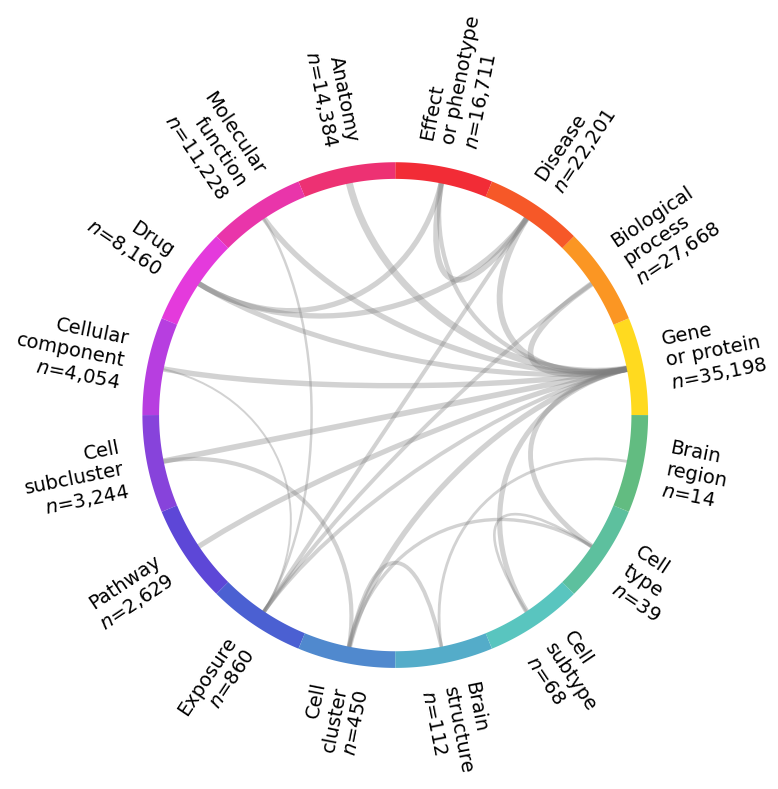

In [6]:
RADIUS_OUTER = 0.82  # outer arc radius
RADIUS_INNER = 0.82  # inner connection radius (where chords meet arcs)
CHORD_ALPHA = 0.35
CHORD_COLOR = "#7f7f7f"

# Setup node order and colors
types = type_counts.index.tolist()
n = len(types)

if CUSTOM_COLORS:
    palette = list(islice(cycle(list(CUSTOM_COLORS)), n))
else:
    cmap = plt.colormaps.get("tab20").resampled(max(12, n))
    palette = [cmap(i) for i in range(n)]
type_to_color = dict(zip(types, palette, strict=False))

# Angles for each node segment
angles = np.linspace(0, 2 * np.pi, n + 1)
type_to_angle = {t: (angles[i], angles[i + 1]) for i, t in enumerate(types)}

# Draw figure
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax.axis("off")

# Draw arcs for each node type (outer ring)
for i, t in enumerate(types):
    start_angle, end_angle = type_to_angle[t]
    arc_angles = np.linspace(start_angle, end_angle, 50)
    x_outer = RADIUS_OUTER * np.cos(arc_angles)
    y_outer = RADIUS_OUTER * np.sin(arc_angles)
    ax.plot(x_outer, y_outer, color=type_to_color[t], lw=12, solid_capstyle="butt")

# Draw chords for type–type connections
for _, row in meta.iterrows():
    t1, t2 = row[pair_cols].tolist()
    count = row["total"]

    if t1 == t2:
        continue  # skip self-loops

    # Use midpoint angles to connect
    a1 = np.mean(type_to_angle[t1])
    a2 = np.mean(type_to_angle[t2])

    # Chord endpoints on inner radius
    x1, y1 = RADIUS_INNER * np.cos(a1), RADIUS_INNER * np.sin(a1)
    x2, y2 = RADIUS_INNER * np.cos(a2), RADIUS_INNER * np.sin(a2)

    # Control points (pull curve inward)
    ctrl_radius = 0.4
    cx1, cy1 = ctrl_radius * np.cos(a1), ctrl_radius * np.sin(a1)
    cx2, cy2 = ctrl_radius * np.cos(a2), ctrl_radius * np.sin(a2)

    verts = [(x1, y1), (cx1, cy1), (cx2, cy2), (x2, y2)]
    codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]

    path = Path(verts, codes)
    patch = PathPatch(
        path,
        facecolor="none",
        edgecolor=CHORD_COLOR,
        lw=0.5 + 4.5 * (np.log1p(count) / np.log1p(meta["total"].max())),
        alpha=CHORD_ALPHA,
    )
    ax.add_patch(patch)


# Generate labels
def process_label(label):
    label = label.replace("_", " ").replace("/", " or ")
    label = label[0].upper() + label[1:]

    # Wrap label if too long
    if " " in label:
        label = label.split(" ")[0] + "\n" + " ".join(label.split(" ")[1:])

    return label


type_labels = [f"{process_label(t)}\n$n$={type_counts.get(t, 1):,d}" for t in types]

# Labels that follow the ring
for i, t in enumerate(types):
    start_angle, end_angle = type_to_angle[t]
    angle = (start_angle + end_angle) / 2
    x = 1.13 * RADIUS_OUTER * np.cos(angle)
    y = 1.13 * RADIUS_OUTER * np.sin(angle)

    # Rotate so text follows the arc direction
    rotation = np.degrees(angle)
    if rotation > 90 and rotation < 270:
        rotation += 180
        ha = "right"
    else:
        ha = "left"

    ax.text(x, y, type_labels[i], ha=ha, va="center", rotation=rotation, rotation_mode="anchor", fontsize=14)

plt.tight_layout()
plt.savefig(conf.paths.notebooks.kg_viz_dir / "metagraph" / "metagraph_circos.png", dpi=600, bbox_inches="tight", transparent=True)
plt.savefig(conf.paths.notebooks.kg_viz_dir / "metagraph" / "metagraph_circos.pdf", bbox_inches="tight", transparent=True)
plt.savefig(conf.paths.notebooks.kg_viz_dir / "metagraph" / "metagraph_circos.svg", bbox_inches="tight", transparent=True)
plt.show()

In [7]:
# Save legend separately
fig_legend, ax_legend = plt.subplots(figsize=(12, 2))
ax_legend.axis("off")

handles = [
    Line2D(
        [],
        [],
        marker="o",
        linestyle="None",
        markerfacecolor=type_to_color[t],
        markeredgecolor="black",
        markersize=10,
        label=t.replace("_", " ").replace("/", " or "),
    )
    for t in types
]

legend = ax_legend.legend(
    handles=handles,
    loc="center",
    frameon=False,
    ncol=8,
    columnspacing=1.5,
    handlelength=1.0,
    fontsize=12,
    title="Node types",
)

fig_legend.savefig(conf.paths.notebooks.kg_viz_dir / "metagraph" / "metagraph_legend.svg", bbox_inches="tight")
fig_legend.savefig(conf.paths.notebooks.kg_viz_dir / "metagraph" / "metagraph_legend.svg", dpi=600, bbox_inches="tight")
fig_legend.savefig(conf.paths.notebooks.kg_viz_dir / "metagraph" / "metagraph_legend.svg", bbox_inches="tight")
plt.close(fig_legend)

## Disease Neighborhoods

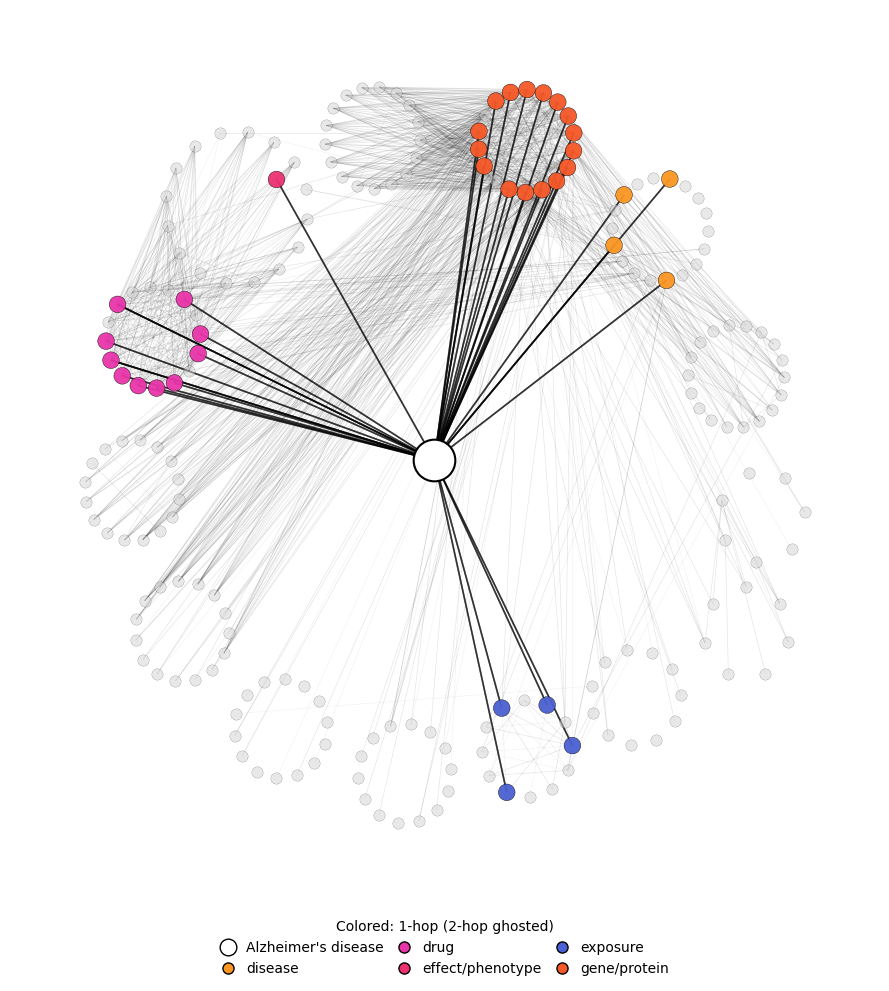

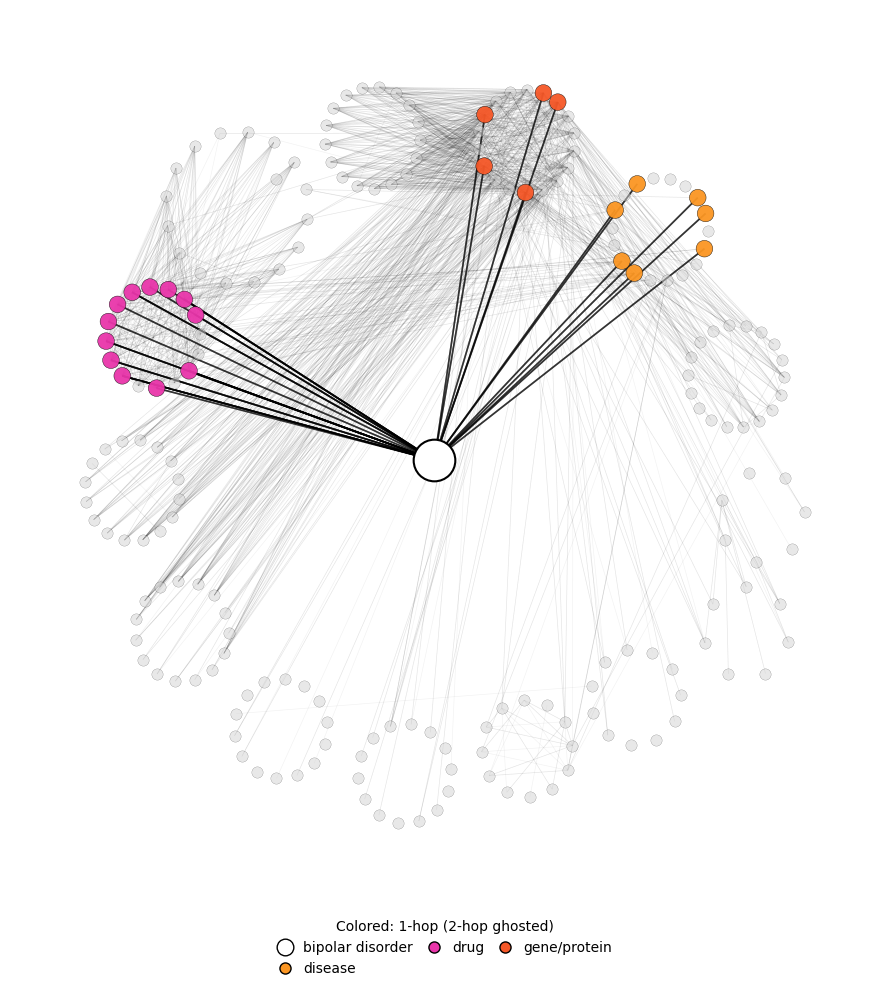

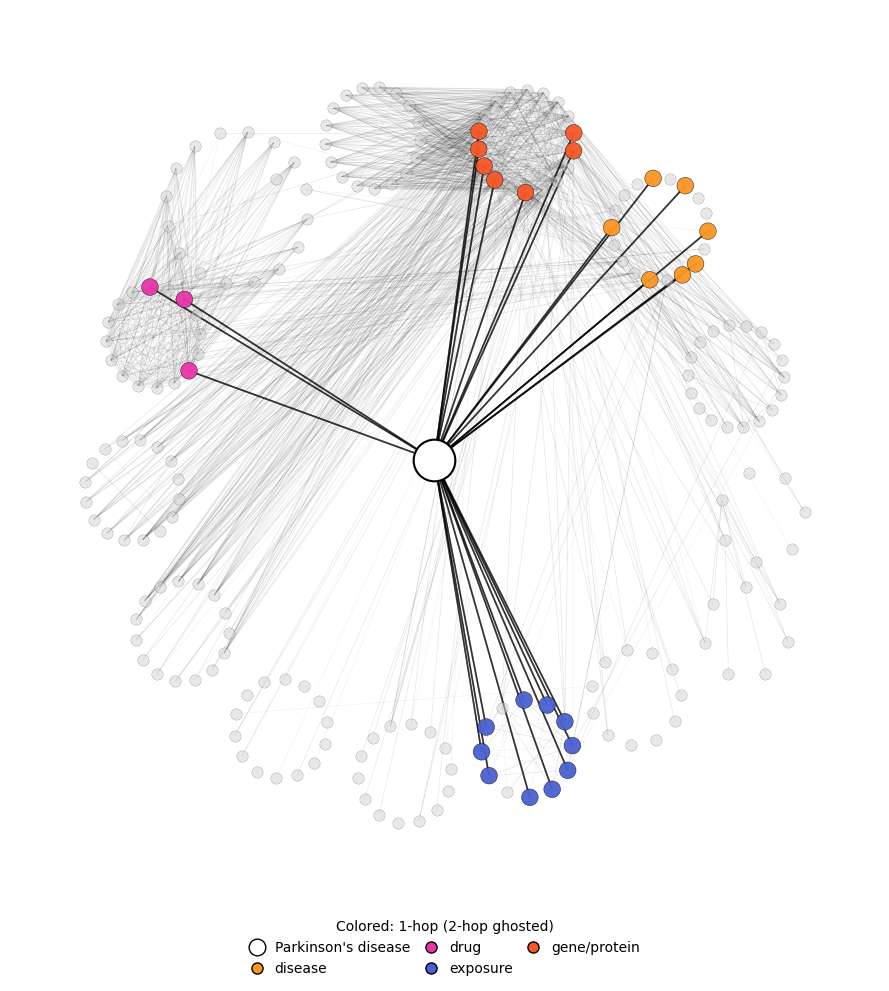

In [8]:
# Configuration
SEEDS = [
    (42049, "Alzheimer's disease"),
    (39528, "bipolar disorder"),
    (39579, "Parkinson's disease"),
]

TOTAL_NEIGHBORS = 200  # total shared neighbors (across all types)
WEIGHT_MODE = "log"  # 'power' | 'log'
ALPHA = 0.5  # used only if WEIGHT_MODE == 'power'
SELECTION_METHOD = "degree"  # 'degree' | 'random' | 'first'
RANDOM_STATE = 42

# Layout config (concentric rings per type wedge)
RADIUS_MODE = "shells"  # 'continuous' | 'shells'
NUM_SHELLS = 3
R_ALPHA = 0.5
R_MIN = 5.5
R_SPAN_PER_100 = 2.5  # span grows with TOTAL_NEIGHBORS
ANGLE_WEIGHT_POW = 0.5
RING_R0_BASE = 1.2
RING_GAP_BASE = 0.55
NODE_SPACING = 0.45  # capacity ≈ 2*pi*r / NODE_SPACING

# Drawing config
DRAW_NEIGHBOR_EDGES = True
MAX_NEIGHBOR_EDGES = 2000
EDGE_ALPHA_NEIGH = 0.12
EDGE_ALPHA_SEED = 0.55

NODE_BASE_SIZE = 120
HOP1_SIZE_MULT = 1.2
HOP2_SIZE_MULT = 0.9
SEED_SIZE = 900

# Ghost nodes not in a given disease's 2-hop
GHOST_OUTSIDE = True
GHOST_ALPHA = 0.50
GHOST_SIZE_MULT = 0.55

rng = np.random.default_rng(RANDOM_STATE)

# Coerce key columns
nodes["node_index"] = nodes["node_index"].astype(int)
edges["x_index"] = edges["x_index"].astype(int)
edges["y_index"] = edges["y_index"].astype(int)

index_to_name = nodes.set_index("node_index")["node_name"].to_dict()
index_to_type = nodes.set_index("node_index")["node_type"].to_dict()

seed_indices = [s for s, _ in SEEDS]
missing = [s for s in seed_indices if s not in index_to_name]
if missing:
    raise ValueError(f"SEED_INDEX values not found in nodes: {missing}")

# Utilities
def twohop_sets(seed_idx: int):
    """Return (hop1, hop2) sets for a seed using undirected adjacency."""
    hop1 = set(edges.loc[edges["x_index"] == seed_idx, "y_index"]).union(
        set(edges.loc[edges["y_index"] == seed_idx, "x_index"])
    )
    mask_h1 = edges["x_index"].isin(hop1) | edges["y_index"].isin(hop1)
    touch_h1 = edges[mask_h1]
    twohop_cands = set(touch_h1.loc[touch_h1["x_index"].isin(hop1), "y_index"]).union(
        set(touch_h1.loc[touch_h1["y_index"].isin(hop1), "x_index"])
    )
    hop2 = twohop_cands - hop1 - {seed_idx}
    return hop1, hop2


def _sort_take(df: pd.DataFrame, k: int, method: str, random_state: int):
    if k <= 0 or df.empty:
        return df.iloc[0:0]
    if method == "degree":
        return df.sort_values(["deg", "node_name"], ascending=[False, True]).head(k)
    elif method == "random":
        return df.sample(n=min(k, len(df)), random_state=random_state)
    else:  # 'first'
        return df.sort_values("node_name", kind="mergesort").head(k)


def ring_capacity(r_local: float) -> int:
    return max(3, int((2 * math.pi * r_local) / NODE_SPACING))


# Build union of 2-hop neighborhoods across the three diseases
seed_to_hops = {}
union_pool = set()
for sid, _ in SEEDS:
    h1, h2 = twohop_sets(sid)
    seed_to_hops[sid] = {"h1": h1, "h2": h2, "all": h1 | h2}
    union_pool |= h1 | h2

if not union_pool:
    raise ValueError("No neighbors found in union of 2-hop neighborhoods.")

pool_nodes = union_pool | set(seed_indices)
pool_edges = edges[edges["x_index"].isin(pool_nodes) & edges["y_index"].isin(pool_nodes)]

# Degree within the pool (for ranking)
deg_counts_pool = pool_edges[["x_index", "y_index"]].stack().value_counts()
deg_series_pool = deg_counts_pool.reindex(list(union_pool), fill_value=0)

# Neighbor table for the pool (hop_any: 1 if 1-hop to ANY seed, else 2)
hop1_any = set().union(*[seed_to_hops[s]["h1"] for s in seed_indices])
neighbor_pool_df = nodes.loc[nodes["node_index"].isin(union_pool), ["node_index", "node_type", "node_name"]].assign(
    hop_any=lambda df: np.where(df["node_index"].isin(hop1_any), 1, 2),
    deg=lambda df: df["node_index"].map(deg_series_pool).fillna(0).astype(int),
)

# Per-type tempered quotas (Hamilton apportionment)
target_total = min(TOTAL_NEIGHBORS, len(union_pool))
types_present = neighbor_pool_df["node_type"].unique()

kg_counts_all = nodes["node_type"].value_counts()
kg_counts_present = kg_counts_all.reindex(types_present).fillna(0).astype(float)

if WEIGHT_MODE == "power":
    w = np.power(kg_counts_present, ALPHA)
elif WEIGHT_MODE == "log":
    w = np.log1p(kg_counts_present)
else:
    raise ValueError("WEIGHT_MODE must be 'power' or 'log'.")
w = w.where(w > 0, 1.0)
weights = w / w.sum()

raw_quota = weights * target_total
alloc_floor = np.floor(raw_quota).astype(int)
remainder = raw_quota - alloc_floor
alloc = alloc_floor.copy()
remaining = target_total - int(alloc.sum())
for t in remainder.sort_values(ascending=False, kind="mergesort").index:
    if remaining <= 0:
        break
    alloc[t] += 1
    remaining -= 1

# Cap by availability and water-fill leftovers
avail_counts = neighbor_pool_df["node_type"].value_counts().reindex(types_present).fillna(0).astype(int)
alloc = np.minimum(alloc, avail_counts)

leftover = target_total - int(alloc.sum())
if leftover > 0:
    capacity = (avail_counts - alloc).clip(lower=0)
    w_cap = w.reindex(capacity.index) * (capacity > 0)
    if w_cap.sum() > 0:
        add_raw = (w_cap / w_cap.sum()) * leftover
        add_floor = np.floor(add_raw).astype(int)
        add_rem = add_raw - add_floor
        add = add_floor.copy()
        rem2 = leftover - int(add.sum())
        for t in add_rem.sort_values(ascending=False, kind="mergesort").index:
            if rem2 <= 0:
                break
            if add[t] < capacity[t]:
                add[t] += 1
                rem2 -= 1
        alloc = (alloc + np.minimum(add, capacity)).astype(int)

# Select nodes within each type quota, preferring hop_any==1
selected_parts = []
for t, g in neighbor_pool_df.groupby("node_type", sort=False):
    quota = int(alloc.get(t, 0))
    if quota <= 0:
        continue
    g1 = g[g["hop_any"] == 1]
    g2 = g[g["hop_any"] == 2]
    take1 = min(quota, len(g1))
    g1_sel = _sort_take(g1, take1, SELECTION_METHOD, RANDOM_STATE)
    g2_sel = _sort_take(g2, quota - take1, SELECTION_METHOD, RANDOM_STATE)
    selected_parts.append(pd.concat([g1_sel, g2_sel], ignore_index=True))

selected_df = pd.concat(selected_parts, ignore_index=True) if selected_parts else neighbor_pool_df.iloc[0:0]
selected_nodes = set(selected_df["node_index"].tolist())
if not selected_nodes:
    raise ValueError("Selection produced zero nodes. Consider increasing TOTAL_NEIGHBORS.")

# One shared layout for selected nodes (based on hop_any)
type_sizes = selected_df["node_type"].value_counts().to_dict()
types_sorted = sorted(type_sizes, key=lambda t: (-type_sizes[t], t))
max_type_size = max(type_sizes.values()) if type_sizes else 1

pos = {}  # node positions


# Hubs per type placed on a circle, wedge proportional to size
def hub_radius(n_t):
    frac = (n_t / max_type_size) ** R_ALPHA
    r = R_MIN + (max(2.0, R_SPAN_PER_100 * (TOTAL_NEIGHBORS / 100.0))) * frac
    if RADIUS_MODE == "shells":
        bins = np.linspace(R_MIN, r, NUM_SHELLS)
        r = bins[np.argmin(np.abs(bins - r))]
    return r


r_hub = {t: hub_radius(type_sizes[t]) for t in types_sorted}
w_angle = np.array([max(1e-6, type_sizes[t] ** ANGLE_WEIGHT_POW) for t in types_sorted])
w_angle /= w_angle.sum()
angle_edges = np.cumsum(np.concatenate([[0], w_angle])) * 2 * np.pi
angle_centers = (angle_edges[:-1] + angle_edges[1:]) / 2.0
for t, theta in zip(types_sorted, angle_centers, strict=False):
    R = r_hub[t]
    pos[f"_hub_{t}"] = np.array([R * np.cos(theta), R * np.sin(theta)])

# Split selected by hop_any for layout rings
sel_h1_by_type = selected_df[selected_df["hop_any"] == 1].groupby("node_type")["node_index"].apply(list).to_dict()
sel_h2_by_type = selected_df[selected_df["hop_any"] == 2].groupby("node_type")["node_index"].apply(list).to_dict()


def cluster_radius_local(n_h1, n_h2, size_frac):
    ring_gap = RING_GAP_BASE * (0.95 + 0.5 * np.sqrt(size_frac))
    r0 = RING_R0_BASE * (0.95 + 0.4 * np.sqrt(size_frac))

    def max_r_for(n):
        left, ring, rmax = n, 0, r0
        while left > 0:
            r_local = r0 + ring * ring_gap
            cap = ring_capacity(r_local)
            left -= cap
            rmax = r_local
            ring += 1
        return rmax

    r1 = max_r_for(n_h1) if n_h1 > 0 else r0
    r2 = max_r_for(n_h2) if n_h2 > 0 else r0
    return max(r1, r2) + NODE_SPACING * 0.6, r0, ring_gap


cluster_R, r0_by_type, gap_by_type = {}, {}, {}
for t in types_sorted:
    size_frac = type_sizes[t] / max_type_size if max_type_size > 0 else 0.0
    n1 = len(sel_h1_by_type.get(t, []))
    n2 = len(sel_h2_by_type.get(t, []))
    cR, r0, gap = cluster_radius_local(n1, n2, size_frac)
    cluster_R[t], r0_by_type[t], gap_by_type[t] = cR, r0, gap

# Push hubs outward until no overlap
OVERLAP_BUFFER = NODE_SPACING * 0.6
for _ in range(60):
    moved = False
    for i in range(len(types_sorted)):
        ti, vi = types_sorted[i], pos[f"_hub_{types_sorted[i]}"]
        for j in range(i + 1, len(types_sorted)):
            tj, vj = types_sorted[j], pos[f"_hub_{types_sorted[j]}"]
            d = np.linalg.norm(vi - vj)
            req = cluster_R[ti] + cluster_R[tj] + OVERLAP_BUFFER
            if d < req:
                delta = (req - d) / 2.0 + 1e-6
                ui = vi / (np.linalg.norm(vi) + 1e-9)
                uj = vj / (np.linalg.norm(vj) + 1e-9)
                pos[f"_hub_{ti}"] = vi + ui * delta
                pos[f"_hub_{tj}"] = vj + uj * delta
                vi, vj = pos[f"_hub_{ti}"], pos[f"_hub_{tj}"]
                moved = True
    if not moved:
        break

# Place nodes on rings (hop_any=1 inner, hop_any=2 outer)
for t in types_sorted:
    hub = pos[f"_hub_{t}"]
    n1 = sel_h1_by_type.get(t, [])
    n2 = sel_h2_by_type.get(t, [])
    r0 = r0_by_type[t]
    gap = gap_by_type[t]
    # hop_any = 1 rings
    left, idx, ring = len(n1), 0, 0
    while left > 0:
        r_local = r0 + ring * gap
        cap = ring_capacity(r_local)
        count = min(cap, left)
        phis = np.linspace(0, 2 * np.pi, count, endpoint=False) + rng.uniform(0, 2 * np.pi)
        for phi in phis:
            if idx >= len(n1):
                break
            pos[n1[idx]] = hub + np.array([r_local * np.cos(phi), r_local * np.sin(phi)])
            idx += 1
        left -= count
        ring += 1
    # hop_any = 2 rings
    start_ring_2 = ring
    left, idx, ring2 = len(n2), 0, 0
    while left > 0:
        r_local = r0 + (start_ring_2 + ring2) * gap
        cap = ring_capacity(r_local)
        count = min(cap, left)
        phis = np.linspace(0, 2 * np.pi, count, endpoint=False) + rng.uniform(0, 2 * np.pi)
        for phi in phis:
            if idx >= len(n2):
                break
            pos[n2[idx]] = hub + np.array([r_local * np.cos(phi), r_local * np.sin(phi)])
            idx += 1
        left -= count
        ring2 += 1

# Colors by type
unique_types = types_sorted
if "CUSTOM_COLORS" in globals() and CUSTOM_COLORS:
    palette = list(islice(cycle(list(CUSTOM_COLORS)), len(unique_types)))
else:
    cmap = plt.colormaps.get("tab20").resampled(max(12, len(unique_types)))
    palette = [cmap(i) for i in range(len(unique_types))]
type_colors = {t: palette[i] for i, t in enumerate(unique_types)}

# Master graph on selected nodes
G_master = nx.Graph()
for n in selected_nodes:
    G_master.add_node(int(n), ntype=str(index_to_type.get(n, "Unknown")), nname=str(index_to_name.get(n, str(n))))
sel_edges = pool_edges[pool_edges["x_index"].isin(selected_nodes) & pool_edges["y_index"].isin(selected_nodes)]
if len(sel_edges) > MAX_NEIGHBOR_EDGES:
    sel_edges = sel_edges.sample(n=MAX_NEIGHBOR_EDGES, random_state=RANDOM_STATE)
G_master.add_edges_from(sel_edges[["x_index", "y_index"]].itertuples(index=False, name=None))

# Ensure seeds exist as nodes in master graph
for sid, _ in SEEDS:
    if sid not in G_master:
        G_master.add_node(
            int(sid), ntype=str(index_to_type.get(sid, "Disease")), nname=str(index_to_name.get(sid, str(sid)))
        )

EDGE_ALPHA_TWOHOP = 0.05  # or e.g., 0.10

def _filter_edges_with_pos(edgelist, pos_dict):
    return [e for e in edgelist if (e[0] in pos_dict) and (e[1] in pos_dict)]



for sid, sname in SEEDS:
    h1, h2 = seed_to_hops[sid]["h1"], seed_to_hops[sid]["h2"]

    # Sets for this seed
    hop1_sel = sorted(selected_nodes & h1)
    hop2_sel = sorted((selected_nodes & h2) - set(hop1_sel))
    in_twohop = set(hop1_sel) | set(hop2_sel)
    ghost_sel = selected_nodes - set(hop1_sel)  # ghost = 2-hop + outside

    # Seed to neighbor edges limited to one-hop
    seed_edges_df = edges[
        ((edges["x_index"] == sid) & (edges["y_index"].isin(hop1_sel)))
        | ((edges["y_index"] == sid) & (edges["x_index"].isin(hop1_sel)))
    ]
    seed_edges_list = list(seed_edges_df[["x_index", "y_index"]].itertuples(index=False, name=None))

    # Neighbor to neighbor edges on the TWO-HOP induced subgraph (hop1 ∪ hop2)
    if DRAW_NEIGHBOR_EDGES and len(sel_edges) > 0:
        mask = sel_edges["x_index"].isin(in_twohop) & sel_edges["y_index"].isin(in_twohop)
        twohop_edges_list = list(sel_edges[mask][["x_index", "y_index"]].itertuples(index=False, name=None))
    else:
        twohop_edges_list = []

    # Per-panel position map that includes the seed at the origin
    pos_this = dict(pos)
    pos_this[sid] = np.array([0.0, 0.0])

    # Filter edges against pos_this
    seed_edges_list = _filter_edges_with_pos(seed_edges_list, pos_this)
    twohop_edges_list = _filter_edges_with_pos(twohop_edges_list, pos_this)

    plt.figure(figsize=(9, 10))

    # Neighbor-neighbor edges (faint; across ONE- and TWO-HOP nodes inside 2-hop)
    if twohop_edges_list:
        nx.draw_networkx_edges(
            G_master, pos_this, edgelist=twohop_edges_list, width=0.5, alpha=EDGE_ALPHA_TWOHOP, arrows=False
        )

    # Edges touching the seed (bold; to ONE-HOP only)
    if seed_edges_list:
        nx.draw_networkx_edges(
            G_master, pos_this, edgelist=seed_edges_list, width=1.2, alpha=EDGE_ALPHA_SEED, arrows=False
        )

    # Nodes inside ONE-HOP (colored by type)
    type_to_nodes_h1 = {}
    for n in hop1_sel:
        t = index_to_type.get(n, "Unknown")
        type_to_nodes_h1.setdefault(t, []).append(n)

    for t in types_sorted:
        lst = type_to_nodes_h1.get(t, [])
        if not lst:
            continue
        nx.draw_networkx_nodes(
            G_master,
            pos_this,
            nodelist=lst,
            node_size=NODE_BASE_SIZE * HOP1_SIZE_MULT,
            node_color=[type_colors[t]] * len(lst),
            edgecolors="black",
            linewidths=0.3,
            node_shape="o",
            alpha=0.95,
        )

    # Ghost nodes (2-hop + outside)
    if GHOST_OUTSIDE and ghost_sel:
        nx.draw_networkx_nodes(
            G_master,
            pos_this,
            nodelist=sorted(ghost_sel),
            node_size=NODE_BASE_SIZE * GHOST_SIZE_MULT,
            node_color="#D3D3D3",
            edgecolors="black",
            linewidths=0.2,
            node_shape="o",
            alpha=GHOST_ALPHA,
        )

    # Draw seed (at origin)
    nx.draw_networkx_nodes(
        G_master,
        pos_this,
        nodelist=[sid],
        node_size=SEED_SIZE,
        node_color="white",
        edgecolors="black",
        linewidths=1.5,
        node_shape="o",
        alpha=1.0,
    )

    # Legend
    handles = [
        Line2D(
            [],
            [],
            marker="o",
            linestyle="None",
            markerfacecolor="white",
            markeredgecolor="black",
            markersize=12,
            label=sname,
        )
    ]
    for t in sorted({index_to_type.get(n, "Unknown") for n in hop1_sel}, key=lambda x: (x not in type_colors, x)):
        if t in type_colors:
            handles.append(
                Line2D(
                    [],
                    [],
                    marker="o",
                    linestyle="None",
                    markerfacecolor=type_colors[t],
                    markeredgecolor="black",
                    markersize=8,
                    label=t.replace("_", " "),
                )
            )
    plt.legend(
        handles=handles,
        frameon=False,
        bbox_to_anchor=(0.5, -0.01),
        loc="upper center",
        title="Colored: 1-hop (2-hop ghosted)",
        ncol=3,
        columnspacing=1.0,
        handlelength=1.0,
    )

    plt.axis("off")
    plt.tight_layout()
    plt.gca().set_facecolor("none")

    # Save neighborhood plots
    seed_name_clean = sname.replace(" ", "_").replace("'", "")
    out_base = f"{seed_name_clean}"
    plt.savefig(
        conf.paths.notebooks.kg_viz_dir / "neighborhood" / f"{out_base}.png",
        dpi=600,
        bbox_inches="tight",
        transparent=True,
    )
    plt.savefig(
        conf.paths.notebooks.kg_viz_dir / "neighborhood" / f"{out_base}.pdf",
        bbox_inches="tight",
        transparent=True,
    )
    plt.savefig(
        conf.paths.notebooks.kg_viz_dir / "neighborhood" / f"{out_base}.svg",
        bbox_inches="tight",
        transparent=True,
    )
    plt.show()